# Posterior entropy
Examine how posterior entropy of $\log(k)$ decreases over trials. We do this evaluation for a number of different design protocols. We also repeat this for varying levels of response errors, $\epsilon$, to test how robust the design protocols are to response errors.

In [1]:
# Point Python to the path where we have installed the bad and darc packages
import sys
sys.path.insert(0, '/Users/btvincent/git-local/darc-experiments-python')

In [2]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import seaborn as sns

import darc
from darc.delayed import models
from darc.designs import BayesianAdaptiveDesignGeneratorDARC, DesignSpaceBuilder
from darc.delayed.designs import Griskevicius2011, Frye, Koffarnus_Bickel, Kirby2009

from darc.data_plotting import plot_delay_without_front_end_delays
from darc_parameter_recovery import simulated_experiment_trial_loop

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

## Define simulation code

In [3]:
def calculate(true_params=pd.DataFrame.from_dict({'logk': [-4], 'α': [2]}),
              N_SIMULATIONS = 500, 
              epsilon_list = [{'ϵ': 0.001}, {'ϵ': 0.01}, {'ϵ': 0.1}]):
    '''Calculate the posterior entropy of logk as a function of experimental 
    trials. Repeated for a range of different design protocols, repeated for 
    a number of different levels of epsilon'''

    all_results = []

    for i, θ_fixed in enumerate(epsilon_list):

        print(f"Epsilson level: {θ_fixed['ϵ']}")

        # create empty lists which will recieve our data.
        logk = []
        method = []
        entropy = []
        trial = []

        for n in range(N_SIMULATIONS):

            print(f'starting simulation {n+1} of {N_SIMULATIONS}')

            # TODO: choose correct prior over logk
            true_params = pd.DataFrame.from_dict({'logk': [norm(-4.5, 1).rvs()], 'α': [2]})

            # Kirby ----------------------------------------------------------------------
            # print('\tKirby')
            design_thing = Kirby2009()
            model = models.Hyperbolic(n_particles=5000)
            model.θ_true = true_params
            model.θ_fixed = θ_fixed  # update to desired ϵ
            _, summary_stats = simulated_experiment_trial_loop(design_thing, model)

            # append to lists
            logk += list(summary_stats['logk_median'].values)
            entropy += list(summary_stats['logk_entropy'].values)
            method += list(['Kirby (2009)'] * summary_stats.shape[0])
            trial += list(summary_stats.index.get_values())

            # Griskevicius2011 ----------------------------------------------------------
            # print('\tGriskevicius2011')
            design_thing = Griskevicius2011()
            model = models.Hyperbolic(n_particles=5000)
            model.θ_true = true_params
            model.θ_fixed = θ_fixed  # update to desired ϵ
            _, summary_stats = simulated_experiment_trial_loop(design_thing, model)

            # append to lists
            logk += list(summary_stats['logk_median'].values)
            entropy += list(summary_stats['logk_entropy'].values)
            method += list(['Griskevicius et al (2011)'] * summary_stats.shape[0])
            trial += list(summary_stats.index.get_values())

            # Koffarnus_Bickel ----------------------------------------------------------
            # print('\tKoffarnus_Bickel')
            design_thing = Koffarnus_Bickel()
            model = models.Hyperbolic(n_particles=5000)
            model.θ_true = true_params
            model.θ_fixed = θ_fixed  # update to desired ϵ
            _, summary_stats = simulated_experiment_trial_loop(design_thing, model)

            # append to lists
            logk += list(summary_stats['logk_median'].values)
            entropy += list(summary_stats['logk_entropy'].values)
            method += list(['Koffarnus & Bickel (2014)'] * summary_stats.shape[0])
            trial += list(summary_stats.index.get_values())

            # Frye ----------------------------------------------------------
            # print('\tFrye')
            design_thing = Frye()
            model = models.Hyperbolic(n_particles=5000)
            model.θ_true = true_params
            model.θ_fixed = θ_fixed  # update to desired ϵ
            _, summary_stats = simulated_experiment_trial_loop(design_thing, model)

            # append to lists
            logk += list(summary_stats['logk_median'].values)
            entropy += list(summary_stats['logk_entropy'].values)
            method += list(['Frye et al (2016)'] * summary_stats.shape[0])
            trial += list(summary_stats.index.get_values())

            # our approach --------------------------------------------------------------
            # print('\tBAD')
            D = DesignSpaceBuilder(RA=list(np.arange(5, 99+1, 1)), 
                                   DB=list(np.arange(1, 365, 7))).build()
            design_thing = BayesianAdaptiveDesignGeneratorDARC(D, max_trials=30)
            model = models.Hyperbolic(n_particles=5000)
            model.θ_true = true_params
            model.θ_fixed = θ_fixed  # update to desired ϵ
            _, summary_stats = simulated_experiment_trial_loop(design_thing, model)

            # append to lists
            logk += list(summary_stats['logk_median'].values)
            entropy += list(summary_stats['logk_entropy'].values)
            method += list(['our approach'] * summary_stats.shape[0])
            trial += list(summary_stats.index.get_values())

        results = pd.DataFrame.from_dict({'logk': logk, 'trial': trial, 'entropy': entropy, 'method': method})
        results['epsilon'] = θ_fixed['ϵ']
        all_results.append(results)

    return pd.concat(all_results)

## Define plot function

In [23]:
def plot_results(all_results, save_name=None):
    fig, ax = plt.subplots(3, 1, figsize=(7, 14), sharex=True, sharey=True)
    sns.set_style("white", {'font.sans-serif': 'DejaVu Sans'})
    sns.set_context("paper", font_scale=1.2, rc={"lines.linewidth": 2.5})
    
    epsilon_list = pd.unique(all_results['epsilon'])

    for i, ϵ in enumerate(epsilon_list):
        data = all_results.loc[all_results['epsilon'] == ϵ]
        sns.lineplot(x='trial', y='entropy', hue='method', data=data, ax=ax[i], ci='sd')
        ax[i].set_ylabel('posterior entropy [bits]')
        ax[i].set_title(f"response error rate, $\epsilon = {ϵ}$")
        ax[i].grid(True)
        
        if i in [1, 2]:
            ax[i].get_legend().remove()
                        
    if save_name is not None:
        fig.savefig(save_name, bbox_inches='tight')

## Decide to load pre-computed results or calculate from scratch

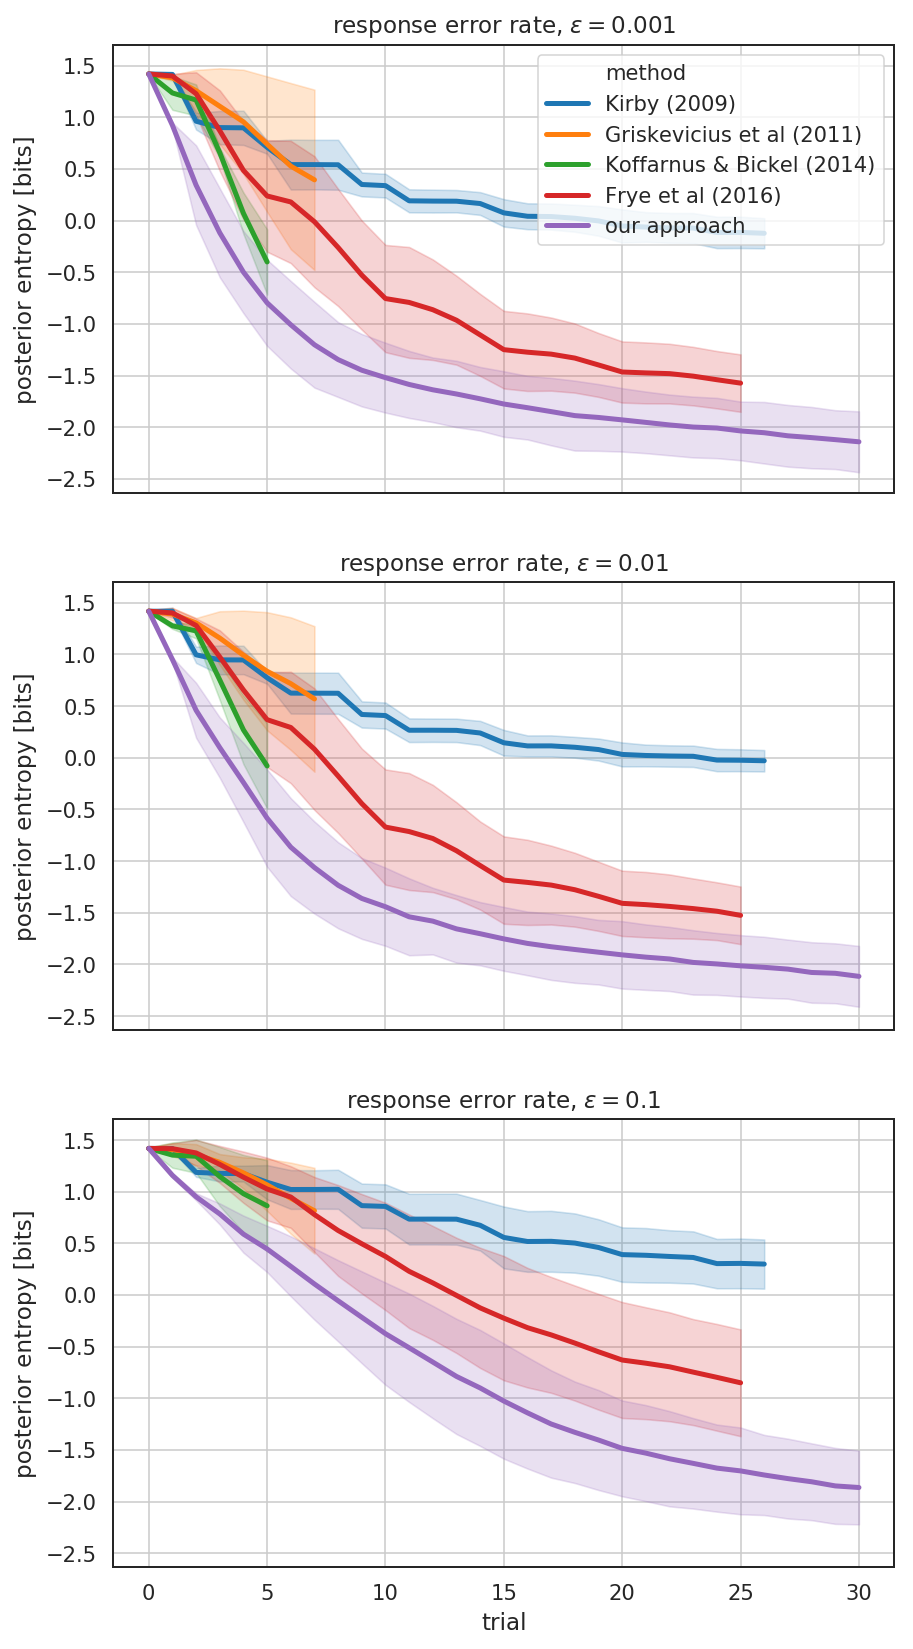

In [24]:
filename = 'posterior_entropy_with_epsilon_results500.csv'

try:
    results = pd.read_csv(filename)
except:
    results = calculate(N_SIMULATIONS = 500)
    results.to_csv(filename)
    
plot_results(results, 
             save_name='posterior_entropy_reduction_epsilon_levels.pdf')
